# End-to-End Classification Pipeline with ML_Engine

This notebook demonstrates a complete machine learning workflow using the `ML_Engine` library and the `ds_sample.csv` dataset. We will cover:

1.  **Setup**: Loading the real dataset and cleaning it.
2.  **Feature Selection**: Running a feature selection experiment to compare different methods.
3.  **Data Transformation**: Applying the chosen feature set to our data.
4.  **Model Comparison**: Running a model comparison experiment to find the best algorithm.
5.  **Hyperparameter Tuning**: Fine-tuning the best model using Optuna.
6.  **Evaluation & Visualization**: Evaluating the final model and visualizing its performance.

## 1. Setup & Data Loading

In [1]:
import pandas as pd
import numpy as np
import os
import yaml
from ML_Engine.data import io, transformation, cleaning
from ML_Engine.features import selection
from ML_Engine.models import training, configs
from ML_Engine.evaluation import metrics
from ML_Engine.visualization import evaluation as vis_eval, style
import matplotlib.pyplot as plt

from ML_Engine.utils.logger import get_logger
logger = get_logger(__name__)

# Set a consistent plot style
style.set_style()


# --- WORKAROUND: Manually load model configs to prevent empty results ---
try:
    base_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
    config_path = os.path.join(base_dir, 'configs', 'model_defaults.yml')
    
    if os.path.exists(config_path) and not configs._MODEL_CONFIGS:
        print(f"Manually loading model configs from: {config_path}")
        with open(config_path, 'r') as f:
            yaml_configs = yaml.safe_load(f)
        
        for problem_type, models in yaml_configs.items():
            for model_name, config in models.items():
                if model_name in configs.MODEL_CLASS_MAP:
                    config['class'] = configs.MODEL_CLASS_MAP[model_name]
        
        configs._MODEL_CONFIGS = yaml_configs
        print("Model configs loaded successfully.")
except Exception as e:
    print(f"Warning: Could not manually load model configs: {e}")
# -----------------------------------------------------------------

# Load Adult Census dataset
data_path = os.path.join('dataset', 'adult_census_sample.csv')
full_df = pd.read_csv(data_path)
print(f"Dataset loaded with shape: {full_df.shape}")

# Define target and features to drop
target_col = 'income'
drop_cols = []  # Adult Census has no metadata columns

# Prepare X and y
X_df = full_df.drop(columns=drop_cols)
y_s = full_df[target_col]

print("Dataset prepared successfully.")
full_df.head()

Manually loading model configs from: D:\OneDrive - STEPLESMOSENSESARL\PlesmoSense-CENTAN\Code\ACHRAF_Private\AUTO_ML_Streamlit\ML_Modules\configs\model_defaults.yml
Model configs loaded successfully.
Dataset loaded with shape: (5000, 15)
Dataset prepared successfully.


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,56,Private,33115,HS-grad,9,Divorced,Other-service,Unmarried,White,Female,0,0,40,United-States,0
1,25,Private,112847,HS-grad,9,Married-civ-spouse,Transport-moving,Own-child,Other,Male,0,0,40,United-States,0
2,43,Private,170525,Bachelors,13,Divorced,Prof-specialty,Not-in-family,White,Female,14344,0,40,United-States,1
3,32,Private,186788,HS-grad,9,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,40,United-States,0
4,39,Private,277886,Bachelors,13,Married-civ-spouse,Sales,Wife,White,Female,0,0,30,United-States,0


## 2. Feature Selection Experiment

First, we'll run a feature selection experiment to see which features different algorithms recommend. We'll use the `default_comparison` experiment defined in our YAML file.

In [2]:
# Define our features and target
target = 'income'
X_full = full_df.drop(columns=[target])
y_full = full_df[target]
# income is already encoded as 0/1, create simple mapping
mapping = {target: {0: 0, 1: 1}}

# Explicitly pass config path
fs_config_path = os.path.join(base_dir, 'configs', 'feature_selection_experiments.yml')

# Run the feature selection experiment
feature_selection_results = selection.run_feature_selection_experiment(
    experiment_name='default_comparison',
    X=X_full,
    y=y_full,
    problem_type='Classification',
    config_path=fs_config_path if os.path.exists(fs_config_path) else None
)

# Inspect the results
for method, features in feature_selection_results.items():
    print(f"Method: {method}\nSelected {len(features)} features: {features}\n")

2026-02-10 22:08:07,484 - ML_Engine.features.selection - INFO - Running feature selection experiment: A standard comparison of Variance, K-Best, and RFE methods.
2026-02-10 22:08:07,485 - ML_Engine.features.selection - INFO - Running method: variance with params: {'threshold': 0.01}
2026-02-10 22:08:07,496 - ML_Engine.features.selection - INFO - Running method: kbest with params: {'k': 10, 'score_func': 'f_classif'}
2026-02-10 22:08:07,509 - ML_Engine.features.selection - INFO - Running method: rfe with params: {'estimator': 'RandomForestClassifier', 'n_features_to_select': 15, 'step': 1}
Method: variance
Selected 14 features: ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']

Method: kbest
Selected 10 features: ['age', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']

## 3. Data Transformation

Based on the results above, let's choose a feature set (e.g., from 'k_best') and transform our data.

In [3]:
# Choose the feature set from k_best
chosen_features = feature_selection_results.get('k_best', [])
if not chosen_features:
    chosen_features = X_full.columns.tolist()[:10]

print(f"Chosen feature set: {chosen_features}")

# Split the full dataset first
X_train_full, X_test_full, y_train, y_test = io.split_data_train_test(X_full, y_full, test_size=0.2, random_state=42)

# Apply feature selection
X_train = transformation.apply_feature_selection(X_train_full, chosen_features)
X_test = transformation.apply_feature_selection(X_test_full, chosen_features)

print(f"Data transformed. X_train shape: {X_train.shape}")

Chosen feature set: ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex']
Data transformed. X_train shape: (4000, 10)


## 4. Model Comparison

Now, we'll run a model comparison experiment to see which algorithm performs best on our selected features.

In [4]:
# Define the models we want to compare
models_to_compare = ['RandomForest', 'XGBoost', 'LightGBM']

results = []
for model_name in models_to_compare:
    print(f"Training {model_name}...")
    model, _ = training.train_model(model_name, X_train, y_train, problem_type='classification')
    
    y_pred = model.predict(X_test)
    metric_results = metrics.get_metric_result(y_test, y_pred, problem_type='classification')
    
    # Extract metrics from the 'target' key (single output)
    if 'target' in metric_results:
        metrics_dict = metric_results['target']
    else:
        # If no 'target' key, assume metrics are at top level
        metrics_dict = metric_results
    metrics_dict['Model'] = model_name
    results.append(metrics_dict)

comparison_df = pd.DataFrame(results)
comparison_df

Training RandomForest...
Training XGBoost...
Training LightGBM...
[LightGBM] [Info] Number of positive: 969, number of negative: 3031
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000141 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 393
[LightGBM] [Info] Number of data points in the train set: 4000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.242250 -> initscore=-1.140383
[LightGBM] [Info] Start training from score -1.140383


,Accuracy,Precision,Recall,F1 Score,Model
0,0.823,0.639175,0.536797,0.583529,RandomForest
1,0.833,0.663265,0.562771,0.608899,XGBoost
2,0.832,0.664921,0.549784,0.601896,LightGBM


## 5. Hyperparameter Tuning

Let's pick the best model and fine-tune it using Optuna.

In [5]:
best_model_name = comparison_df.sort_values(by='Accuracy', ascending=False).iloc[0]['Model']
print(f"Best model for tuning: {best_model_name}")

# Run hyperparameter tuning
best_params, study = training.tune_hyperparameters(
    model_name=best_model_name,
    X_train=X_train,
    y_train=y_train,
    problem_type='classification',
    n_trials=10
)

print(f"Best parameters found: {best_params}")

[I 2026-02-10 22:08:08,861] A new study created in memory with name: no-name-43b30c4e-afb5-4397-b7bf-a0992db4b637


Best model for tuning: XGBoost


[I 2026-02-10 22:08:11,513] Trial 0 finished with value: 0.8242500000000001 and parameters: {}. Best is trial 0 with value: 0.8242500000000001.
[I 2026-02-10 22:08:13,371] Trial 1 finished with value: 0.8242500000000001 and parameters: {}. Best is trial 0 with value: 0.8242500000000001.
[I 2026-02-10 22:08:15,319] Trial 2 finished with value: 0.8242500000000001 and parameters: {}. Best is trial 0 with value: 0.8242500000000001.
[I 2026-02-10 22:08:17,211] Trial 3 finished with value: 0.8242500000000001 and parameters: {}. Best is trial 0 with value: 0.8242500000000001.
[I 2026-02-10 22:08:17,326] Trial 4 finished with value: 0.8242500000000001 and parameters: {}. Best is trial 0 with value: 0.8242500000000001.
[I 2026-02-10 22:08:17,434] Trial 5 finished with value: 0.8242500000000001 and parameters: {}. Best is trial 0 with value: 0.8242500000000001.
[I 2026-02-10 22:08:17,554] Trial 6 finished with value: 0.8242500000000001 and parameters: {}. Best is trial 0 with value: 0.8242500000

Best parameters found: {}


## 6. Final Evaluation & Visualization

Finally, we train the best model with optimized parameters and visualize its performance.

Final XGBoost Metrics:
- Accuracy: 0.8330
- Precision: 0.6633
- Recall: 0.5628
- F1 Score: 0.6089
Plot saved to: outputs\01_Full_Classification_Pipeline\confusion_matrix.png


<Figure size 1000x800 with 0 Axes>

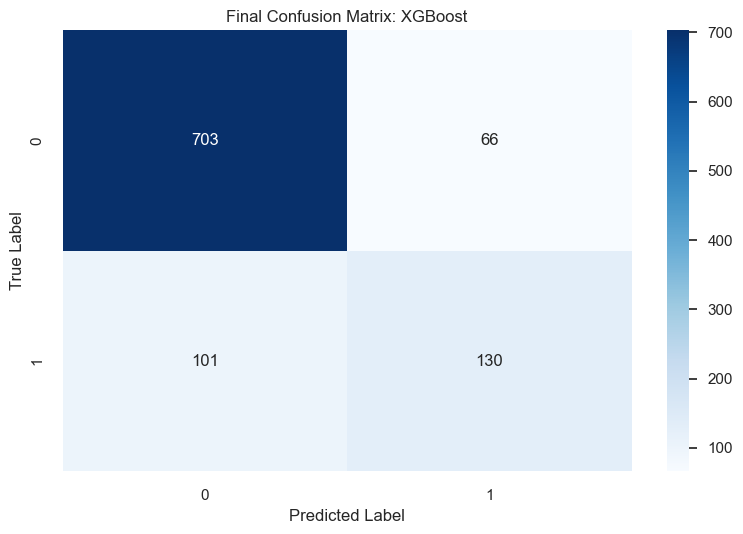

In [6]:
# Train final model
final_model, _ = training.train_model(
    best_model_name, 
    X_train, 
    y_train, 
    problem_type='classification', 
    model_params=best_params
)

# Evaluate
y_pred = final_model.predict(X_test)
final_metrics = metrics.get_metric_result(y_test, y_pred, problem_type='classification')
print(f"Final {best_model_name} Metrics:")
# Extract metrics from nested dictionary
if 'target' in final_metrics:
    metrics_dict = final_metrics['target']
else:
    metrics_dict = final_metrics
for metric, value in metrics_dict.items():
    print(f"- {metric}: {value:.4f}")

# Visualize Confusion Matrix
class_names = list(mapping[target].keys())
plt.figure(figsize=(10, 8))
vis_eval.plot_confusion_matrix(y_test, y_pred, labels=class_names)
plt.title(f"Final Confusion Matrix: {best_model_name}")

# Save the plot
output_dir = os.path.join('outputs', '01_Full_Classification_Pipeline')
os.makedirs(output_dir, exist_ok=True)
plot_path = os.path.join(output_dir, 'confusion_matrix.png')
plt.tight_layout()
plt.savefig(plot_path, dpi=150)
print(f"Plot saved to: {plot_path}")

plt.show()